In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Failed to initialize NVML: Driver/library version mismatch
/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  96
  On-line CPU(s) list:   0-95
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Gold 6248R CPU @ 3.00GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  24
    Socket(s):           2
    Stepping:            7
    CPU max MHz:         4000.0000
    CPU min MHz:         1200.0000
    BogoMIPS:            6000.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflus

In [2]:
import math
import numpy as np
import meshio
import toughio
import torch
import torch.nn.functional as F
import torch.nn as nn

import shape_functions_31 as sf
import shape_functions_16_new_v3 as sf_16
import space_filling_curves as sfc
import copy
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.tri as tri
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
filename = 'Mesh/2d_fpc_refine_2.stl'
mesh = toughio.read_mesh(filename)
mesh

<toughio mesh object>
  Number of points: 17752
  Number of cells:
    triangle: 34896
  Cell data: facet_normals, material

In [4]:
temp = copy.deepcopy(mesh.cells[0][1][:,-1]) 
mesh.cells[0][1][:,-1] = mesh.cells[0][1][:,2]
mesh.cells[0][1][:,2] = mesh.cells[0][1][:,1]
mesh.cells[0][1][:,1] = temp
nonods = mesh.n_points
nloc = 3
totele = mesh.n_cells
ndglno = mesh.cells[0][1].flatten() + 1  # add 1 to each value (tweak initial index from 0 to 1)

In [5]:
x_all = [[], []]
for node in ndglno:
    x_all[0].append(mesh.points[node-1][1])
    x_all[1].append(mesh.points[node-1][0])

In [6]:
# create the a matrix
adjacency_matrix = torch.eye(nonods)
# populate the connections with a one 
for element in mesh.cells[0][1]:
#     print(element)
    for i in element:
        for j in element:
            if adjacency_matrix[i][j] != 1:
                adjacency_matrix[i][j] = 1

In [7]:
adjacency_matrix.shape

torch.Size([17752, 17752])

In [8]:
a_indices = adjacency_matrix.nonzero().t().contiguous()
cola = adjacency_matrix.nonzero().t()[1] + 1
fina = np.zeros(nonods+1)
fina_value = 1
i=0
for occurrence in torch.bincount(adjacency_matrix.nonzero().t()[0]):
    fina[i] = fina_value
    fina_value += occurrence.item()
    i += 1
fina[-1] = fina_value
fina = fina.astype(int)
ncola=cola.shape[0]

# Define parameters

In [9]:
# define variables
dt = 0.01              # Time step (s)
ub = 1.0              # Inflow velocity (m/s) don't set 0.1!
Re = 0.1               # Reynodls number 
alpha = 1/3           # Jacobi relaxation
relax_keep_off = 0.8
nfilt_size_sfc= 0
scale_matrices = True   # scale sfc and original meshes by ml or not
lvl_start_jac = 1       # level to start jacobi iteration, default is 1
# SFCs variables
ncurve = 1 # number of sfcs
graph_trim = -10  # has always been set at -10
starting_node = 0 # set -1 to switch on the new sfc code 

In [10]:
# diffusion stencil correct 
a_dif, b_dif, ml_dif = sf_16.get_fe_matrix_eqn(x_all= x_all,u=np.array([[0]*nonods,[0]*nonods]).astype(float), 
                                            k=np.array([Re]*nonods).astype(float), 
                                            sig=np.array([0]*nonods).astype(float), 
                                            s=np.array([0]*nonods).astype(float),
                                            fina=fina,cola=cola,ncola=ncola,ndglno=ndglno,nonods=nonods,
                                            totele=totele,nloc=nloc,ndim=2,ele_type=100)
# advection stencil in x direction 
a_adv_x, b_adv_x, ml_adv_x = sf_16.get_fe_matrix_eqn(x_all= x_all,u=np.array([[0]*nonods,[ub]*nonods]).astype(float), 
                                            k=np.array([0.0]*nonods).astype(float), 
                                            sig=np.array([0]*nonods).astype(float), 
                                            s=np.array([0]*nonods).astype(float),
                                            fina=fina,cola=cola,ncola=ncola,ndglno=ndglno,nonods=nonods,
                                            totele=totele,nloc=nloc,ndim=2,ele_type=100)
# advection stencil in y direction 
a_adv_y, b_adv_y, ml_adv_y = sf_16.get_fe_matrix_eqn(x_all= x_all,u=np.array([[ub]*nonods,[0]*nonods]).astype(float), 
                                            k=np.array([0.0]*nonods).astype(float), 
                                            sig=np.array([0]*nonods).astype(float), 
                                            s=np.array([0]*nonods).astype(float),
                                            fina=fina,cola=cola,ncola=ncola,ndglno=ndglno,nonods=nonods,
                                            totele=totele,nloc=nloc,ndim=2,ele_type=100)
# multigrid
a_mg, b_mg, ml_mg = sf_16.get_fe_matrix_eqn(x_all= x_all,u=np.array([[0]*nonods,[0]*nonods]).astype(float), 
                                            k=np.array([1.0]*nonods).astype(float), 
                                            sig=np.array([0]*nonods).astype(float), 
                                            s=np.array([0]*nonods).astype(float),
                                            fina=fina,cola=cola,ncola=ncola,ndglno=ndglno,nonods=nonods,
                                            totele=totele,nloc=nloc,ndim=2,ele_type=100)

 going into get_shape_funs_with_faces
 just about to allocate
 nloc, sngi, ngi, ndim, nface,max_face_list_no:           3           2           3           2           3           2
 npoly,ele_type:           1         100
 here 1
 here 2
 here 3
 going into get_shape_funs ***is a triangle or tet
 out of get_shape_funs
 going into SPECTR
 just leaving spectr
 out of SPECTR
 going into SPECTR
 just leaving spectr
 out of SPECTR
 going into get_shape_funs_with_faces
 just about to allocate
 nloc, sngi, ngi, ndim, nface,max_face_list_no:           3           2           3           2           3           2
 npoly,ele_type:           1         100
 here 1
 here 2
 here 3
 going into get_shape_funs ***is a triangle or tet
 out of get_shape_funs
 going into SPECTR
 just leaving spectr
 out of SPECTR
 going into SPECTR
 just leaving spectr
 out of SPECTR
 going into get_shape_funs_with_faces
 just about to allocate
 nloc, sngi, ngi, ndim, nface,max_face_list_no:           3           2     

# Formulate matrices for the momentum and the continuty equations

In [11]:
indices_ml = torch.zeros((2,mesh.points.shape[0]))
for i in range(mesh.points.shape[0]):
    indices_ml[0][i] = i
    indices_ml[1][i] = i
indices_ml = indices_ml.int()
# convert ml matrix to sparse matrix --> diffusion term
ml_dif_sparse = torch.sparse_coo_tensor(indices_ml, ml_dif, (nonods,nonods))
ml_dif_inv_sparse = torch.sparse_coo_tensor(indices_ml, 1/ml_dif, (nonods,nonods))
a_dif_sparse = torch.sparse_coo_tensor(a_indices, a_dif, (nonods, nonods))
# convert ml matrix to sparse matrix --> advection term
ml_adv_x_sparse = torch.sparse_coo_tensor(indices_ml, ml_adv_x, (nonods,nonods))
ml_adv_x_inv_sparse = torch.sparse_coo_tensor(indices_ml, 1/ml_adv_x, (nonods,nonods)) 
a_adv_x_sparse = torch.sparse_coo_tensor(a_indices, a_adv_x, (nonods, nonods))
# convert ml matrix to sparse matrix --> advection term
ml_adv_y_sparse = torch.sparse_coo_tensor(indices_ml, ml_adv_y, (nonods,nonods))
ml_adv_y_inv_sparse = torch.sparse_coo_tensor(indices_ml, 1/ml_adv_y, (nonods,nonods))
a_adv_y_sparse = torch.sparse_coo_tensor(a_indices, a_adv_y, (nonods, nonods))
# make b a tensor
b_dif = torch.Tensor(b_dif)
b_adv_x = torch.Tensor(b_adv_x)
b_adv_y = torch.Tensor(b_adv_y)

In [12]:
ml_dif.shape

(17752,)

# Formulate matrices for SFC-multigrid 

In [13]:
def get_boundary_nonboundary_nodes(mesh=mesh): 
    ''' Function to get boundary and non-boundary nodes of the mesh'''
    
    boundary_nodes = []
    non_boundary_nodes = []
    
    x_min = mesh.points.transpose()[0].min()
    x_max = mesh.points.transpose()[0].max()
    y_min = mesh.points.transpose()[1].min()
    y_max = mesh.points.transpose()[1].max()
    for i in range(nonods):
        if mesh.points.transpose()[0][i] == 10000000:
            boundary_nodes.append(i)
        else:
            non_boundary_nodes.append(i)
    return boundary_nodes, non_boundary_nodes

In [14]:
# Get boundary and non-boundary nodes
boundary_nodes = get_boundary_nonboundary_nodes()[0]
non_boundary_nodes = get_boundary_nonboundary_nodes()[1]

In [15]:
np.shape(non_boundary_nodes)

(17752,)

In [16]:
# values_new_a_mg = a_mg
# new_nonods = nonods

# new_a_mg = a_mg
# new_b_mg = b_mg
# new_ml_mg = ml_mg

# new_ml_mg_sparse = torch.sparse_coo_tensor(indices_ml, ml_mg, (new_nonods,new_nonods))
# new_ml_mg_sparse_inv = torch.sparse_coo_tensor(indices_ml, 1/ml_mg, (new_nonods,new_nonods))
# new_a_mg_sparse = torch.sparse_coo_tensor(a_indices, values_new_a_mg, (new_nonods,new_nonods))


# new_a_mg_sparse = torch.sparse.mm(new_ml_mg_sparse_inv, new_a_mg_sparse)
# new_b_mg = new_b_mg/new_ml_mg

# new_a_mg_sparse = torch.sparse.mm(new_ml_mg_sparse_inv, new_a_mg_sparse)
# new_b_mg = new_b_mg/new_ml_mg

In [17]:
# First, get a matrix and convert to sparse
a_mg_sparse = torch.sparse_coo_tensor(a_indices, a_mg, (nonods, nonods))
new_a_mg = np.delete(np.delete(np.array(a_mg_sparse.to_dense()), boundary_nodes, 0), boundary_nodes, 1)
new_b_mg = np.delete(b_mg, boundary_nodes, 0)
new_ml_mg = np.delete(ml_mg, boundary_nodes, 0)

new_nonods = new_a_mg.shape[0]
# Convert new_a to sparse
new_a_indices = np.array(new_a_mg.nonzero())
values_new_a_mg = new_a_mg[new_a_indices[0], new_a_indices[1]]
#new_a_sparse = torch.new_a.nonzero()
new_a_mg_sparse = torch.sparse_coo_tensor(new_a_indices, values_new_a_mg, (new_nonods,new_nonods))

indices_ml_new = torch.zeros((2,new_nonods))
for i in range(new_nonods):
    indices_ml_new[0][i] = i
    indices_ml_new[1][i] = i

indices_ml_new = indices_ml_new.int()
new_ml_mg_sparse = torch.sparse_coo_tensor(indices_ml_new, new_ml_mg, (new_nonods,new_nonods))
new_ml_mg_sparse_inv = torch.sparse_coo_tensor(indices_ml_new, 1/new_ml_mg, (new_nonods,new_nonods))

# simply divide new_a_sparse and new_b by new_ml
#if scale_matrices == True:
# new_a_mg_sparse = torch.sparse.mm(new_ml_mg_sparse_inv, new_a_mg_sparse)
# new_b_mg = new_b_mg/new_ml_mg

In [18]:
# Get new fina and cola values
new_a_indices = torch.Tensor(new_a_mg).nonzero().t()
cola = new_a_indices[1] + 1
fina = np.zeros(new_nonods+1)
fina_value = 1
i=0
for occurrence in torch.bincount(new_a_indices[0]):
    fina[i] = fina_value
    fina_value += occurrence.item()
    i += 1
fina[-1] = fina_value
fina = fina.astype(int)
ncola = cola.shape[0]

In [19]:
whichd, space_filling_curve_numbering = sfc.ncurve_python_subdomain_space_filling_curve(cola, 
                                                                                        fina, 
                                                                                        starting_node,
                                                                                        graph_trim, 
                                                                                        ncurve, 
                                                                                        new_nonods, 
                                                                                        ncola)

In [20]:
N = len(space_filling_curve_numbering)
inverse_numbering = np.zeros((N, ncurve), dtype=int)
inverse_numbering[:, 0] = np.argsort(space_filling_curve_numbering[:, 0])
max_nlevel = 100 #sf.calculate_nlevel_sfc(new_nonods) + 1
max_nonods_sfc_all_grids = 5*nonods 
max_ncola_sfc_all_un = 5*ncola

In [21]:
a_sfc, fina_sfc_all_un, cola_sfc_all_un, ncola_sfc_all_un, b_sfc, ml_sfc, fin_sfc_nonods, nonods_sfc_all_grids, nlevel = sf.best_sfc_mapping_to_sfc_matrix_unstructured(a=values_new_a_mg,b=new_b_mg, ml=new_ml_mg,
                                                                                                                    fina=fina,cola=cola,
                                                                                                                    sfc_node_ordering=space_filling_curve_numbering[:,0], 
                                                                                                                    ncola=ncola,nonods=new_nonods,
                                                                                                                    max_nonods_sfc_all_grids=max_nonods_sfc_all_grids,
                                                                                                                    max_ncola_sfc_all_un=max_ncola_sfc_all_un,
                                                                                                                    max_nlevel=max_nlevel)


 2-just inside best_sfc_mapping_to_sfc_matrix_unstructured
 here 2
 ---max_ncola_sfc_all_un,ncola,nlevel:      615240      123048          16
 ---nonods,nonods_sfc_all_grids:       17752       35510
 fin_sfc_nonods(1:,nlevel+1):           1       17753       26629       31067       33286       34396       34951       35229       35368       35438       35473       35491       35500       35505       35508       35510       35511
 --- ilevel=           1
 here2
 fin_sfc_nonods(ilevel),fin_sfc_nonods(ilevel+1):           1       17753
 diff=       17752
 fina_sfc_all_un(fin_sfc_nonods(ilevel)):           1
 fina_sfc_all_un(fin_sfc_nonods(ilevel+1))-1:      123048
 difference:      123048
 --- ilevel=           2
 here2
 fin_sfc_nonods(ilevel),fin_sfc_nonods(ilevel+1):       17753       26629
 diff=        8876
 fina_sfc_all_un(fin_sfc_nonods(ilevel)):      123049
 fina_sfc_all_un(fin_sfc_nonods(ilevel+1))-1:      185714
 difference:       62666
 --- ilevel=           3
 here2
 fin_sfc_no

In [22]:
a_sfc = torch.Tensor(a_sfc)
b_sfc = torch.Tensor(b_sfc)
ml_sfc = torch.Tensor(ml_sfc)

In [23]:
a_sfc.shape

torch.Size([615240])

In [24]:
def get_a_ml_b(level, fin_sfc_nonods=fin_sfc_nonods, a_sfc=a_sfc, b_sfc=b_sfc, ml_sfc=ml_sfc, nfilt_size_sfc=nfilt_size_sfc, scale_matrices=scale_matrices):
    '''Function to get a, b ml and ml inverse in sfc ordering for each level as sparse matrices
    
        Input
        ---------------------------------------------------------------------------------------------
        level: Level to get sfc ordering starting from 0 as the first
        curve: the sfc curve to consider
        fin_sfc_nonods: List containing the starting index in a_sfc of each level
        a_sfc = list containing a_sfcs in different SFC ordering
        b_sfc = list containing b_sfcs in different SFC ordering
        ml_sfc = list containing ml_sfcs in different SFC ordering
        
        Output
        ---------------------------------------------------------------------------------------------
        a_sfc_level_sparse: a matrix in SFC ordering for specified level
        b_sfc_level: b vector in SFC ordering for specified level
        diagonal: Diagonal values in a_sfc_level_sparse
        nonods: Number of nodes in specified level
    '''
    # level 0 is the highest level
    # level nlevel-1 is the lowest level
    # subtracting 1 because fortran indexes from 1 but python indexes from 0
#     print(level)
    start_index = fin_sfc_nonods[level] - 1
    end_index = fin_sfc_nonods[level + 1] - 1
#     print(start_index,end_index)
    nonods = end_index - start_index
    a_sfc_level = torch.zeros((nonods,nonods))
    diagonal = torch.zeros((1,nonods))
    #---------------------------- get a_sfc_level-------------------------------#
    for i in range(start_index,end_index):
#        print(i,fina_sfc_all_un[i],fina_sfc_all_un[i+1]-1)
#        print("-------")
        for j in range(fina_sfc_all_un[i]-1,fina_sfc_all_un[i+1]-1):
#             print(j,i-start_index,cola_sfc_all_un[j]-1-start_index)
            a_sfc_level[i-start_index][cola_sfc_all_un[j]-1-start_index] = a_sfc[j]
#        print("-------")
    
    # find the diag index
#---------------------------- get a_sfc_level-------------------------------#

#print(diagonal.shape)
#print("=======")
    for i in range(nonods):
        i = i + start_index
#         print('i=',i, 'j_start:', fina_sfc_all_un[i]-1, 'j_end:', fina_sfc_all_un[i+1]-1)
#         print('---------')
        for j in range(fina_sfc_all_un[i]-1,fina_sfc_all_un[i+1]-1):
            temp = cola_sfc_all_un[j]-1
#             print('j=',j,i-start_index,temp)
            if (i==temp):
#                 print(i,j)
                diagonal[0][i-start_index] = a_sfc[j]
#         print('---------')
    #----------- convert a_sfc_level to sparse --------------#
    # get indices
    a_sfc_level_indices = a_sfc_level.nonzero().t()
    # get values
    a_sfc_level_values = a_sfc_level[a_sfc_level_indices[0], a_sfc_level_indices[1]]
    a_sfc_level_sparse = torch.sparse_coo_tensor(a_sfc_level_indices, a_sfc_level_values, (nonods, nonods))
    #-----------get ml_sfc_level and its inverse and convert  to sparse ----------#
    ml_sfc_level = ml_sfc[start_index:end_index]
    #indices
    ml_sfc_level_indices = torch.zeros((2,nonods))
    ml_sfc_level_indices[0] = torch.Tensor([i for i in range(nonods)])
    ml_sfc_level_indices[1] = ml_sfc_level_indices[0]
    ml_sfc_level_indices = ml_sfc_level_indices.int()
    # convert to sparse
    ml_sfc_level_sparse = torch.sparse_coo_tensor(ml_sfc_level_indices, ml_sfc_level, (nonods, nonods))
    # inverse
    ml_sfc_level_sparse_inv = torch.sparse_coo_tensor(ml_sfc_level_indices, 1/ml_sfc_level, (nonods, nonods))
    #---------------------------- get b_sfc -----------------------------------#
    b_sfc_level = b_sfc[start_index:end_index]
    #----------------------- Divide each one by ml_sfc_level ------------------#
#     if scale_matrices == True: 
#         a_sfc_level_sparse = torch.sparse.mm(ml_sfc_level_sparse_inv, a_sfc_level_sparse)
#         b_sfc_level = b_sfc_level/ml_sfc_level
    #  ml_sfc_level_sparse, ml_sfc_level_sparse_inv,
    return a_sfc_level_sparse, b_sfc_level, diagonal, nonods

In [25]:

levels = [level for level in range(nlevel)]

# ------------------------------- FIRST CURVE -----------------------------#
variables_sfc = list(map(get_a_ml_b, levels))


In [26]:
variables_sfc

[(tensor(indices=tensor([[    0,     0,     0,  ..., 17751, 17751, 17751],
                         [    0,     1,     2,  ..., 17749, 17750, 17751]]),
         values=tensor([ 7.0742, -0.9287, -1.2886,  ..., -0.8100, -1.5987,
                         7.3108]),
         size=(17752, 17752), nnz=123048, layout=torch.sparse_coo),
  tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  tensor([[7.0742, 7.4979, 7.5614,  ..., 7.0896, 7.3278, 7.3108]]),
  17752),
 (tensor(indices=tensor([[   0,    0,    0,  ..., 8875, 8875, 8875],
                         [   0,    1,    3,  ..., 8870, 8874, 8875]]),
         values=tensor([12.7147, -3.7934, -1.6587,  ..., -0.9755, -3.5699,
                        11.4411]),
         size=(8876, 8876), nnz=62666, layout=torch.sparse_coo),
  tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  tensor([[12.7147, 11.8890, 11.8293,  ..., 11.5127, 12.1025, 11.4411]]),
  8876),
 (tensor(indices=tensor([[   0,    0,    0,  ..., 4437, 4437, 4437],
                         [   0,    1,    

In [27]:
class GNN_mg(nn.Module):
    def __init__(self):
        super(GNN_mg, self).__init__()
    
    def forward(self, level, Tn, variables_sfc=variables_sfc):
        '''Convolutional Neural Network to multiply the scalar field by the scaled FEM matrix
        
        Input
        ----------------------------------------------------------------------------------------------
        level: Grid level of the agglomerated mesh. Level 0 is the finest grid and level nlevel-1 is the lowest grid with nonods=1
        curve: The SFC curve to consider; 0 or 1
        Tn: The current scalar field
        variables_sfc: List that contains the a, b, diagonal weights in a and nonods in specified level for both SFCs
        
        Output
        ----------------------------------------------------------------------------------------------
        Tn_1: The next solution of the scalar field
        
        '''
        # get a_sfc and ml_sfc for this level and curve
        a_sfc_sparse, b_sfc_level, diag_weights, nonods_level = variables_sfc[level]
        
        # timestep
        Tn_1 = torch.sparse.mm(a_sfc_sparse, Tn.view(nonods_level,1))
            
        return Tn_1.view(1,1,nonods_level), diag_weights.view(1,1,nonods_level)

In [28]:
CNN1D_res = nn.Conv1d(1, 1, kernel_size=2, stride=2, padding='valid', bias=False) 
filter_ = torch.Tensor([[0.5, 0.5]]).float().view(1, 1, 2) 
CNN1D_res.weight.data = filter_

In [29]:
CNN1D_prol = nn.Upsample(scale_factor=2)

In [30]:
nodes_per_level = [fin_sfc_nonods[i] - fin_sfc_nonods[i-1] for i in range(1, nlevel+1)]

In [31]:
d = torch.Tensor(
    [new_a_mg_sparse[i][i].item() for i in range(new_nonods)]).view(1,1,new_nonods)

# GNN functions for momentum equation

In [32]:
filt_dif = torch.sparse.mm(-ml_dif_inv_sparse, (dt * a_dif_sparse))
filt_adv_x = torch.sparse.mm(-ml_adv_x_inv_sparse, (dt * a_adv_x_sparse))
filt_adv_y = torch.sparse.mm(-ml_adv_y_inv_sparse, (dt * a_adv_y_sparse))
filt_source_x = a_adv_x_sparse/(dt)
filt_source_y = a_adv_y_sparse/(dt)
print(filt_dif.shape)

torch.Size([17752, 17752])


In [33]:
class GNN_dif(nn.Module):
    def __init__(self):
        super(GNN_dif, self).__init__()
    def forward(self, values, filt = filt_dif):
        # Get weights and time step
        values = torch.sparse.mm(filt, values.view(nonods, 1))
        return values   
class GNN_adv_x(nn.Module):
    def __init__(self):
        super(GNN_adv_x, self).__init__()
    def forward(self, values, filt = filt_adv_x):
        # Get weights and time step
        values = torch.sparse.mm(filt, values.view(nonods, 1))
        return values  
class GNN_adv_y(nn.Module):
    def __init__(self):
        super(GNN_adv_y, self).__init__()
    def forward(self, values, filt = filt_adv_y):
        # Get weights and time step
        values = torch.sparse.mm(filt, values.view(nonods, 1))
        return values  
class GNN_source_x(nn.Module):
    def __init__(self):
        super(GNN_source_x, self).__init__()
    def forward(self, values, filt = filt_source_x):
        # Get weights and time step
        values = torch.sparse.mm(filt, values.view(nonods, 1))
        return values  
class GNN_source_y(nn.Module):
    def __init__(self):
        super(GNN_source_y, self).__init__()
    def forward(self, values, filt = filt_source_y):
        # Get weights and time step
        values = torch.sparse.mm(filt, values.view(nonods, 1))
        return values 

# Functions for Boundary conditions.






In [34]:
mesh_x = mesh.points.transpose()[0]
mesh_y = mesh.points.transpose()[1]
print(mesh_x.shape,np.max(mesh_x),np.max(mesh_y))

(17752,) 300.0 100.0


In [35]:
body_x = []
for i in range(mesh_x.shape[0]):
    radius = ((mesh_y[i]-50)**2 + (mesh_x[i]-75)**2)**0.5
    if radius <= 10.5:
        body_x.append(i)

In [36]:
WBC = np.where(mesh_x==0)
EBC = np.where(mesh_x==np.max(mesh_x))
NBC = np.where(mesh_y==0)
SBC = np.where(mesh_y==np.max(mesh_y))
print(np.shape(NBC),np.shape(SBC),np.shape(WBC),np.shape(EBC))

(1, 178) (1, 178) (1, 51) (1, 77)


In [37]:
def boundary_condition_velocity(values_u,values_v):  
#     values_u[SBC] = 0.0
#     values_u[NBC] = 0.0
    values_u[EBC] = ub*1.0 # very important to get stable
    values_u[WBC] = ub*1.0
    
    values_v[NBC] = 0.0
    values_v[SBC] = 0.0
    values_v[EBC] = 0.0
    values_v[WBC] = 0.0   
    
#     values_u[body_x] = 0.0
#     values_v[body_x] = 0.0
    return values_u,values_v

def boundary_condition_pressure(values):
#     values[WBC] = 0.0
    values[EBC] = 0.0
#     values[SBC] = 0.0
#     values[NBC] = 0.0
#     values[body_x] = 0.0
    return values

def boundary_condition_source(values):
    values[WBC] = 0.0
    values[EBC] = 0.0
    values[SBC] = 0.0
    values[NBC] = 0.0
#     values[body_x] = 0.0
    return values


# Initial velocity and pressure field 
# Build up models 

In [38]:
values_u = torch.zeros(nonods,1)
values_v = torch.zeros(nonods,1)
values_p = torch.zeros(nonods,1)
sigma = torch.zeros(nonods,1)

multi_itr = 5        # Iterations of multi-grid 
j_itr = 1            # Iterations of Jacobi 
ntime = 10000    # Time steps
n_out = 500           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0 
mgsolver = True
save_fig = False
Restart = False
ctime = 0             
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
import time

model_dif = GNN_dif()
model_adv_x = GNN_adv_x()
model_adv_y = GNN_adv_y()
model_su_x = GNN_source_x()
model_su_y = GNN_source_y()
model_mg = GNN_mg()

Mesh resolution: torch.Size([17752, 1])
Time step: 10000
Initial time: 0


In [39]:
temp_u = np.loadtxt('results/Mesh2_BC/u50000.csv', delimiter = ',')
temp_v = np.loadtxt('results/Mesh2_BC/v50000.csv', delimiter = ',')
temp_p = np.loadtxt('results/Mesh2_BC/p50000.csv', delimiter = ',')
values_u = torch.Tensor(temp_u).view(nonods,1)
values_v = torch.Tensor(temp_v).view(nonods,1)
values_p = torch.Tensor(temp_p).view(nonods,1)

In [40]:
sigma[body_x] = 1000000
n = 50000

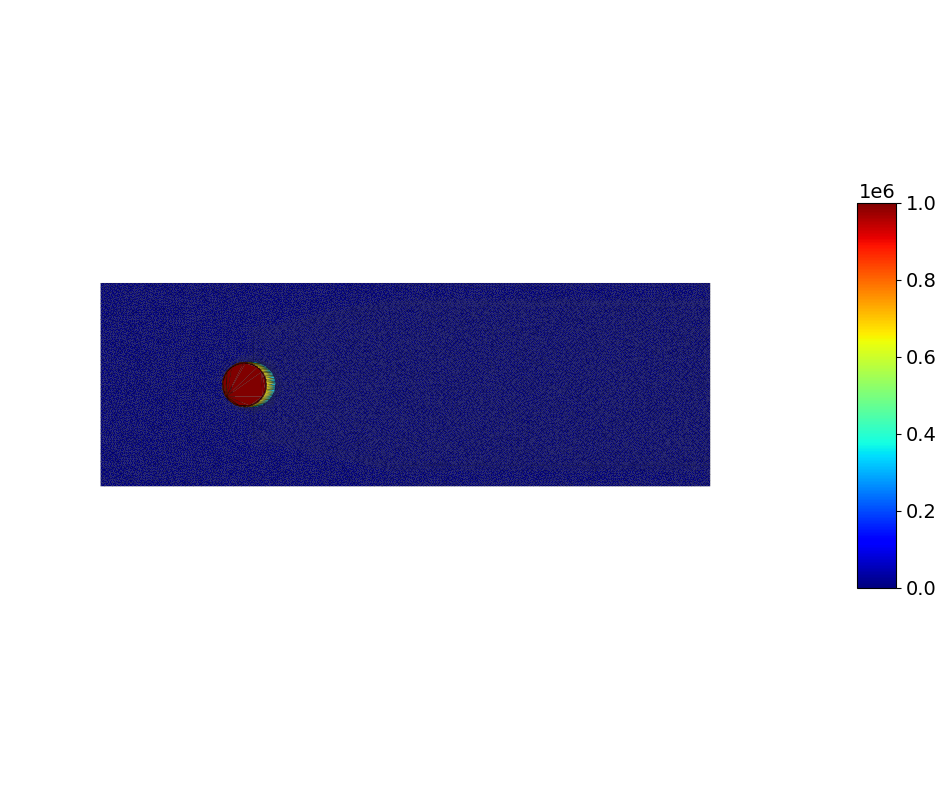

In [41]:
# Creating figure
fig = plt.figure(figsize =(20, 10)) 
ax = plt.axes(projection ='3d') 
 
# Creating color map
my_cmap = plt.get_cmap('jet')
   
# Creating plot
trisurf = ax.plot_trisurf(mesh.points.transpose()[0], mesh.points.transpose()[1], 
                          sigma.detach().numpy()[:,0],cmap = my_cmap,
                          linewidth = 0.1,
                          antialiased = True,
                          edgecolor = 'black') 
c = fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 10)
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([3,1,1])
plt.axis('off')
# fig_name = "legend.jpg"
# plt.savefig(fig_name, dpi=200, bbox_inches='tight')
# show plot
plt.show()

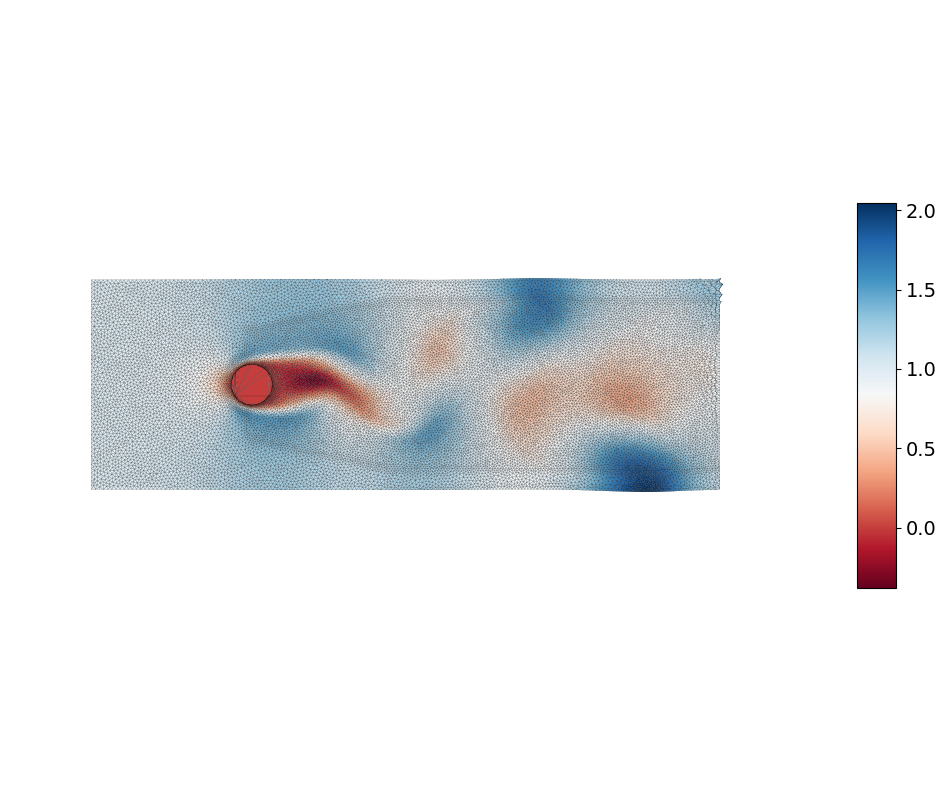

In [42]:
# Creating figure
fig = plt.figure(figsize =(20, 10)) 
ax = plt.axes(projection ='3d') 
 
# Creating color map
my_cmap = plt.get_cmap('RdBu')
   
# Creating plot
trisurf = ax.plot_trisurf(mesh.points.transpose()[0], mesh.points.transpose()[1], 
                          values_u.detach().numpy()[:,0],cmap = my_cmap,
                          linewidth = 0.1,
                          antialiased = True,
                          edgecolor = 'black') 
c = fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 10)
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([3,1,1])
plt.axis('off')
# fig_name = "legend.jpg"
# plt.savefig(fig_name, dpi=200, bbox_inches='tight')
# show plot
plt.show()

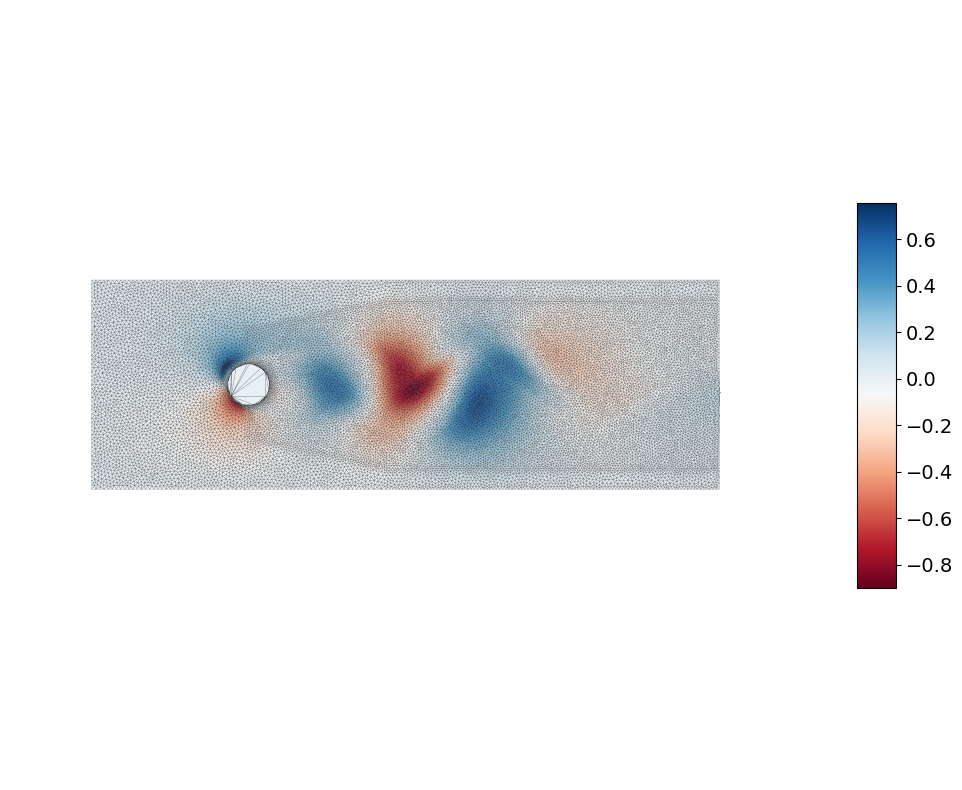

In [43]:
# Creating figure
fig = plt.figure(figsize =(20, 10)) 
ax = plt.axes(projection ='3d') 
 
# Creating color map
my_cmap = plt.get_cmap('RdBu')
   
# Creating plot
trisurf = ax.plot_trisurf(mesh.points.transpose()[0], mesh.points.transpose()[1], 
                          values_v.detach().numpy()[:,0],cmap = my_cmap,
                          linewidth = 0.1,
                          antialiased = True,
                          edgecolor = 'black') 
c = fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 10)
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([3,1,1])
plt.axis('off')
# fig_name = "legend.jpg"
# plt.savefig(fig_name, dpi=200, bbox_inches='tight')
# show plot
plt.show()

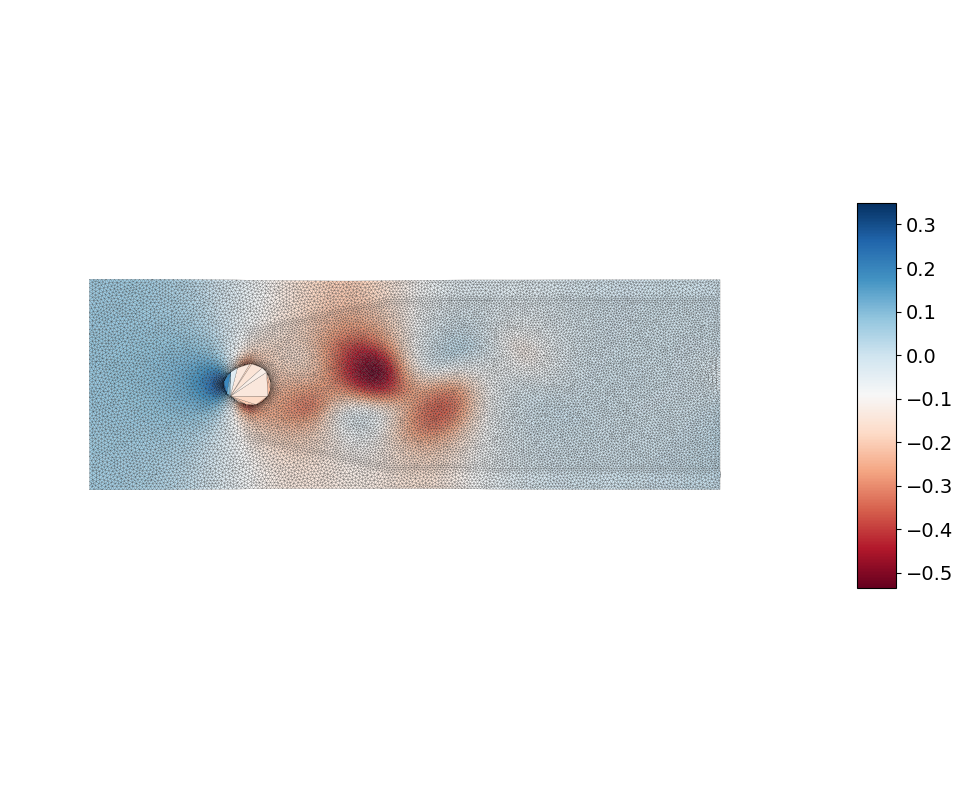

In [44]:
# Creating figure
fig = plt.figure(figsize =(20, 10)) 
ax = plt.axes(projection ='3d') 
 
# Creating color map
my_cmap = plt.get_cmap('RdBu')
   
# Creating plot
trisurf = ax.plot_trisurf(mesh.points.transpose()[0], mesh.points.transpose()[1], 
                          -values_p.detach().numpy()[:,0],cmap = my_cmap,
                          linewidth = 0.1,
                          antialiased = True,
                          edgecolor = 'black') 
c = fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 10)
ax.view_init(elev=90, azim=-90)
ax.set_box_aspect([3,1,1])
plt.axis('off')
# fig_name = "legend.jpg"
# plt.savefig(fig_name, dpi=200, bbox_inches='tight')
# show plot
plt.show()

# Solve Navier-Stokes equations by GNN

In [43]:
start = time.time()
for itime in range(1,ntime+1):
    [values_u,values_v] = boundary_condition_velocity(values_u,values_v)
    values_p = boundary_condition_pressure(values_p)
# =================== Two-stepping scheme for advection and diffusion ===================
    a_u = model_dif(values_u) + \
    values_u*model_adv_x(values_u) + \
    values_v*model_adv_y(values_u)
    b_u = 0.5*a_u + values_u
    a_v = model_dif(values_v) + \
    values_u*model_adv_x(values_v) + \
    values_v*model_adv_y(values_v)    
    b_v = 0.5*a_v + values_v
    [b_u,b_v] = boundary_condition_velocity(b_u,b_v)
    c_u = model_dif(b_u) + \
    b_u*model_adv_x(b_u) + \
    b_v*model_adv_y(b_u)  
    values_u = values_u + c_u  
    c_v = model_dif(b_v) + \
    b_u*model_adv_x(b_v) + \
    b_v*model_adv_y(b_v)    
    values_v = values_v + c_v
# =======================================================================================
    values_u = values_u /(1+dt*sigma)
    values_v = values_v /(1+dt*sigma)
# ===================== preassure gradient to correct velocity ==========================          
    values_u = values_u - model_adv_x(values_p)
    values_v = values_v - model_adv_y(values_p)  
    [values_u,values_v] = boundary_condition_velocity(values_u,values_v)
# =======================================================================================
# ===================== Multigrid for Poisson equation ==================================          
    new_b = (model_su_x(values_u) + model_su_y(values_v)) 
    new_b = boundary_condition_source(new_b)
    if mgsolver == True:
        for multi_grid in range(multi_itr):
            w = torch.zeros([1,1,2])
            r = new_b.view(1,1,new_nonods) - (torch.sparse.mm(new_a_mg_sparse, 
                                 values_p.view(new_nonods,1))).view(1,1,new_nonods)
            r[0,0,EBC] = 0
            r = (r[0][0].T[inverse_numbering[:,0]].T).view(1,1,new_nonods)              
            r_s = []
            r_s.append(r)
            for i in range(1,nlevel-1):
                r = F.pad(r, (0,1), "constant", 0)
                r[0,0,r.shape[2]-1] = r[0,0,r.shape[2]-2]
                r = CNN1D_res(r)
                r_s.append(r)     
            for i in reversed(range(1,nlevel-1)):
                for Jacobi in range(j_itr):
                    w = w - alpha*(model_mg(i, w)[0]/model_mg(i, w)[1]) + alpha*(r_s[i]/model_mg(i, w)[1])
                    CNN1D_prol_odd = nn.Upsample(scale_factor=nodes_per_level[i-1]/nodes_per_level[i])
                    w = CNN1D_prol_odd(w) 
# #         # Map w to original order
            w = (w[0][0].T[space_filling_curve_numbering[:,0]-1].T).view(1,1,new_nonods)
# # #        # Put r_s[0] in original order as well
            r_final = (r_s[0][0][0].T[space_filling_curve_numbering[:,0]-1].T).view(1,1,new_nonods)
# # # #------Perform Jacobi relaxation on finest mesh using original residual -----------------------------------------------------------
            A_ = (torch.sparse.mm(new_a_mg_sparse, w.view(new_nonods,1))).view(1,1,new_nonods)                
            w = w - alpha*(A_/d) + alpha*(r_final/d)
            values_p = values_p + w.view(new_nonods,1)
            values_p = boundary_condition_pressure(values_p)

# -------------------------------------------------------------------------------------------------------------------------------------- 
# ===================== preassure gradient to correct velocity ==========================   
    values_p = boundary_condition_pressure(values_p)
    values_u = values_u - model_adv_x(values_p)
    values_v = values_v - model_adv_y(values_p)     
    [values_u,values_v] = boundary_condition_velocity(values_u,values_v) 
# ======================================================================================= 
    values_u = values_u /(1+dt*sigma)
    values_v = values_v /(1+dt*sigma)
    if itime % n_out == 0:
        np.savetxt("results/Mesh2_BC/u"+str(n+itime)+".csv", values_u.detach().numpy(), delimiter=',')
        np.savetxt("results/Mesh2_BC/v"+str(n+itime)+".csv", values_v.detach().numpy(), delimiter=',')
        np.savetxt("results/Mesh2_BC/p"+str(n+itime)+".csv", values_p.detach().numpy(), delimiter=',')
    print('Time step:', itime)
end = time.time()
print('time',(end-start))

/tmp/ipykernel_1747440/747801405.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  r[0,0,EBC] = 0
/tmp/ipykernel_1747440/747801405.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2985.)
  r = (r[0][0].T[inverse_numbering[:,0]].T).view(1,1,new_nonods)


Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
Time step: 20
Time step: 21
Time step: 22
Time step: 23
Time step: 24
Time step: 25
Time step: 26
Time step: 27
Time step: 28
Time step: 29
Time step: 30
Time step: 31
Time step: 32
Time step: 33
Time step: 34
Time step: 35
Time step: 36
Time step: 37
Time step: 38
Time step: 39
Time step: 40
Time step: 41
Time step: 42
Time step: 43
Time step: 44
Time step: 45
Time step: 46
Time step: 47
Time step: 48
Time step: 49
Time step: 50
Time step: 51
Time step: 52
Time step: 53
Time step: 54
Time step: 55
Time step: 56
Time step: 57
Time step: 58
Time step: 59
Time step: 60
Time step: 61
Time step: 62
Time step: 63
Time step: 64
Time step: 65
Time step: 66
Time step: 67
Time step: 68
Time step: 69
Time step: 70
Time step: 71
Time step: 72
T

Time step: 556
Time step: 557
Time step: 558
Time step: 559
Time step: 560
Time step: 561
Time step: 562
Time step: 563
Time step: 564
Time step: 565
Time step: 566
Time step: 567
Time step: 568
Time step: 569
Time step: 570
Time step: 571
Time step: 572
Time step: 573
Time step: 574
Time step: 575
Time step: 576
Time step: 577
Time step: 578
Time step: 579
Time step: 580
Time step: 581
Time step: 582
Time step: 583
Time step: 584
Time step: 585
Time step: 586
Time step: 587
Time step: 588
Time step: 589
Time step: 590
Time step: 591
Time step: 592
Time step: 593
Time step: 594
Time step: 595
Time step: 596
Time step: 597
Time step: 598
Time step: 599
Time step: 600
Time step: 601
Time step: 602
Time step: 603
Time step: 604
Time step: 605
Time step: 606
Time step: 607
Time step: 608
Time step: 609
Time step: 610
Time step: 611
Time step: 612
Time step: 613
Time step: 614
Time step: 615
Time step: 616
Time step: 617
Time step: 618
Time step: 619
Time step: 620
Time step: 621
Time step:

Time step: 1096
Time step: 1097
Time step: 1098
Time step: 1099
Time step: 1100
Time step: 1101
Time step: 1102
Time step: 1103
Time step: 1104
Time step: 1105
Time step: 1106
Time step: 1107
Time step: 1108
Time step: 1109
Time step: 1110
Time step: 1111
Time step: 1112
Time step: 1113
Time step: 1114
Time step: 1115
Time step: 1116
Time step: 1117
Time step: 1118
Time step: 1119
Time step: 1120
Time step: 1121
Time step: 1122
Time step: 1123
Time step: 1124
Time step: 1125
Time step: 1126
Time step: 1127
Time step: 1128
Time step: 1129
Time step: 1130
Time step: 1131
Time step: 1132
Time step: 1133
Time step: 1134
Time step: 1135
Time step: 1136
Time step: 1137
Time step: 1138
Time step: 1139
Time step: 1140
Time step: 1141
Time step: 1142
Time step: 1143
Time step: 1144
Time step: 1145
Time step: 1146
Time step: 1147
Time step: 1148
Time step: 1149
Time step: 1150
Time step: 1151
Time step: 1152
Time step: 1153
Time step: 1154
Time step: 1155
Time step: 1156
Time step: 1157
Time ste

Time step: 1609
Time step: 1610
Time step: 1611
Time step: 1612
Time step: 1613
Time step: 1614
Time step: 1615
Time step: 1616
Time step: 1617
Time step: 1618
Time step: 1619
Time step: 1620
Time step: 1621
Time step: 1622
Time step: 1623
Time step: 1624
Time step: 1625
Time step: 1626
Time step: 1627
Time step: 1628
Time step: 1629
Time step: 1630
Time step: 1631
Time step: 1632
Time step: 1633
Time step: 1634
Time step: 1635
Time step: 1636
Time step: 1637
Time step: 1638
Time step: 1639
Time step: 1640
Time step: 1641
Time step: 1642
Time step: 1643
Time step: 1644
Time step: 1645
Time step: 1646
Time step: 1647
Time step: 1648
Time step: 1649
Time step: 1650
Time step: 1651
Time step: 1652
Time step: 1653
Time step: 1654
Time step: 1655
Time step: 1656
Time step: 1657
Time step: 1658
Time step: 1659
Time step: 1660
Time step: 1661
Time step: 1662
Time step: 1663
Time step: 1664
Time step: 1665
Time step: 1666
Time step: 1667
Time step: 1668
Time step: 1669
Time step: 1670
Time ste

Time step: 2122
Time step: 2123
Time step: 2124
Time step: 2125
Time step: 2126
Time step: 2127
Time step: 2128
Time step: 2129
Time step: 2130
Time step: 2131
Time step: 2132
Time step: 2133
Time step: 2134
Time step: 2135
Time step: 2136
Time step: 2137
Time step: 2138
Time step: 2139
Time step: 2140
Time step: 2141
Time step: 2142
Time step: 2143
Time step: 2144
Time step: 2145
Time step: 2146
Time step: 2147
Time step: 2148
Time step: 2149
Time step: 2150
Time step: 2151
Time step: 2152
Time step: 2153
Time step: 2154
Time step: 2155
Time step: 2156
Time step: 2157
Time step: 2158
Time step: 2159
Time step: 2160
Time step: 2161
Time step: 2162
Time step: 2163
Time step: 2164
Time step: 2165
Time step: 2166
Time step: 2167
Time step: 2168
Time step: 2169
Time step: 2170
Time step: 2171
Time step: 2172
Time step: 2173
Time step: 2174
Time step: 2175
Time step: 2176
Time step: 2177
Time step: 2178
Time step: 2179
Time step: 2180
Time step: 2181
Time step: 2182
Time step: 2183
Time ste

Time step: 2635
Time step: 2636
Time step: 2637
Time step: 2638
Time step: 2639
Time step: 2640
Time step: 2641
Time step: 2642
Time step: 2643
Time step: 2644
Time step: 2645
Time step: 2646
Time step: 2647
Time step: 2648
Time step: 2649
Time step: 2650
Time step: 2651
Time step: 2652
Time step: 2653
Time step: 2654
Time step: 2655
Time step: 2656
Time step: 2657
Time step: 2658
Time step: 2659
Time step: 2660
Time step: 2661
Time step: 2662
Time step: 2663
Time step: 2664
Time step: 2665
Time step: 2666
Time step: 2667
Time step: 2668
Time step: 2669
Time step: 2670
Time step: 2671
Time step: 2672
Time step: 2673
Time step: 2674
Time step: 2675
Time step: 2676
Time step: 2677
Time step: 2678
Time step: 2679
Time step: 2680
Time step: 2681
Time step: 2682
Time step: 2683
Time step: 2684
Time step: 2685
Time step: 2686
Time step: 2687
Time step: 2688
Time step: 2689
Time step: 2690
Time step: 2691
Time step: 2692
Time step: 2693
Time step: 2694
Time step: 2695
Time step: 2696
Time ste

Time step: 3149
Time step: 3150
Time step: 3151
Time step: 3152
Time step: 3153
Time step: 3154
Time step: 3155
Time step: 3156
Time step: 3157
Time step: 3158
Time step: 3159
Time step: 3160
Time step: 3161
Time step: 3162
Time step: 3163
Time step: 3164
Time step: 3165
Time step: 3166
Time step: 3167
Time step: 3168
Time step: 3169
Time step: 3170
Time step: 3171
Time step: 3172
Time step: 3173
Time step: 3174
Time step: 3175
Time step: 3176
Time step: 3177
Time step: 3178
Time step: 3179
Time step: 3180
Time step: 3181
Time step: 3182
Time step: 3183
Time step: 3184
Time step: 3185
Time step: 3186
Time step: 3187
Time step: 3188
Time step: 3189
Time step: 3190
Time step: 3191
Time step: 3192
Time step: 3193
Time step: 3194
Time step: 3195
Time step: 3196
Time step: 3197
Time step: 3198
Time step: 3199
Time step: 3200
Time step: 3201
Time step: 3202
Time step: 3203
Time step: 3204
Time step: 3205
Time step: 3206
Time step: 3207
Time step: 3208
Time step: 3209
Time step: 3210
Time ste

Time step: 3662
Time step: 3663
Time step: 3664
Time step: 3665
Time step: 3666
Time step: 3667
Time step: 3668
Time step: 3669
Time step: 3670
Time step: 3671
Time step: 3672
Time step: 3673
Time step: 3674
Time step: 3675
Time step: 3676
Time step: 3677
Time step: 3678
Time step: 3679
Time step: 3680
Time step: 3681
Time step: 3682
Time step: 3683
Time step: 3684
Time step: 3685
Time step: 3686
Time step: 3687
Time step: 3688
Time step: 3689
Time step: 3690
Time step: 3691
Time step: 3692
Time step: 3693
Time step: 3694
Time step: 3695
Time step: 3696
Time step: 3697
Time step: 3698
Time step: 3699
Time step: 3700
Time step: 3701
Time step: 3702
Time step: 3703
Time step: 3704
Time step: 3705
Time step: 3706
Time step: 3707
Time step: 3708
Time step: 3709
Time step: 3710
Time step: 3711
Time step: 3712
Time step: 3713
Time step: 3714
Time step: 3715
Time step: 3716
Time step: 3717
Time step: 3718
Time step: 3719
Time step: 3720
Time step: 3721
Time step: 3722
Time step: 3723
Time ste

Time step: 4176
Time step: 4177
Time step: 4178
Time step: 4179
Time step: 4180
Time step: 4181
Time step: 4182
Time step: 4183
Time step: 4184
Time step: 4185
Time step: 4186
Time step: 4187
Time step: 4188
Time step: 4189
Time step: 4190
Time step: 4191
Time step: 4192
Time step: 4193
Time step: 4194
Time step: 4195
Time step: 4196
Time step: 4197
Time step: 4198
Time step: 4199
Time step: 4200
Time step: 4201
Time step: 4202
Time step: 4203
Time step: 4204
Time step: 4205
Time step: 4206
Time step: 4207
Time step: 4208
Time step: 4209
Time step: 4210
Time step: 4211
Time step: 4212
Time step: 4213
Time step: 4214
Time step: 4215
Time step: 4216
Time step: 4217
Time step: 4218
Time step: 4219
Time step: 4220
Time step: 4221
Time step: 4222
Time step: 4223
Time step: 4224
Time step: 4225
Time step: 4226
Time step: 4227
Time step: 4228
Time step: 4229
Time step: 4230
Time step: 4231
Time step: 4232
Time step: 4233
Time step: 4234
Time step: 4235
Time step: 4236
Time step: 4237
Time ste

Time step: 4689
Time step: 4690
Time step: 4691
Time step: 4692
Time step: 4693
Time step: 4694
Time step: 4695
Time step: 4696
Time step: 4697
Time step: 4698
Time step: 4699
Time step: 4700
Time step: 4701
Time step: 4702
Time step: 4703
Time step: 4704
Time step: 4705
Time step: 4706
Time step: 4707
Time step: 4708
Time step: 4709
Time step: 4710
Time step: 4711
Time step: 4712
Time step: 4713
Time step: 4714
Time step: 4715
Time step: 4716
Time step: 4717
Time step: 4718
Time step: 4719
Time step: 4720
Time step: 4721
Time step: 4722
Time step: 4723
Time step: 4724
Time step: 4725
Time step: 4726
Time step: 4727
Time step: 4728
Time step: 4729
Time step: 4730
Time step: 4731
Time step: 4732
Time step: 4733
Time step: 4734
Time step: 4735
Time step: 4736
Time step: 4737
Time step: 4738
Time step: 4739
Time step: 4740
Time step: 4741
Time step: 4742
Time step: 4743
Time step: 4744
Time step: 4745
Time step: 4746
Time step: 4747
Time step: 4748
Time step: 4749
Time step: 4750
Time ste

Time step: 5203
Time step: 5204
Time step: 5205
Time step: 5206
Time step: 5207
Time step: 5208
Time step: 5209
Time step: 5210
Time step: 5211
Time step: 5212
Time step: 5213
Time step: 5214
Time step: 5215
Time step: 5216
Time step: 5217
Time step: 5218
Time step: 5219
Time step: 5220
Time step: 5221
Time step: 5222
Time step: 5223
Time step: 5224
Time step: 5225
Time step: 5226
Time step: 5227
Time step: 5228
Time step: 5229
Time step: 5230
Time step: 5231
Time step: 5232
Time step: 5233
Time step: 5234
Time step: 5235
Time step: 5236
Time step: 5237
Time step: 5238
Time step: 5239
Time step: 5240
Time step: 5241
Time step: 5242
Time step: 5243
Time step: 5244
Time step: 5245
Time step: 5246
Time step: 5247
Time step: 5248
Time step: 5249
Time step: 5250
Time step: 5251
Time step: 5252
Time step: 5253
Time step: 5254
Time step: 5255
Time step: 5256
Time step: 5257
Time step: 5258
Time step: 5259
Time step: 5260
Time step: 5261
Time step: 5262
Time step: 5263
Time step: 5264
Time ste

Time step: 5717
Time step: 5718
Time step: 5719
Time step: 5720
Time step: 5721
Time step: 5722
Time step: 5723
Time step: 5724
Time step: 5725
Time step: 5726
Time step: 5727
Time step: 5728
Time step: 5729
Time step: 5730
Time step: 5731
Time step: 5732
Time step: 5733
Time step: 5734
Time step: 5735
Time step: 5736
Time step: 5737
Time step: 5738
Time step: 5739
Time step: 5740
Time step: 5741
Time step: 5742
Time step: 5743
Time step: 5744
Time step: 5745
Time step: 5746
Time step: 5747
Time step: 5748
Time step: 5749
Time step: 5750
Time step: 5751
Time step: 5752
Time step: 5753
Time step: 5754
Time step: 5755
Time step: 5756
Time step: 5757
Time step: 5758
Time step: 5759
Time step: 5760
Time step: 5761
Time step: 5762
Time step: 5763
Time step: 5764
Time step: 5765
Time step: 5766
Time step: 5767
Time step: 5768
Time step: 5769
Time step: 5770
Time step: 5771
Time step: 5772
Time step: 5773
Time step: 5774
Time step: 5775
Time step: 5776
Time step: 5777
Time step: 5778
Time ste

Time step: 6230
Time step: 6231
Time step: 6232
Time step: 6233
Time step: 6234
Time step: 6235
Time step: 6236
Time step: 6237
Time step: 6238
Time step: 6239
Time step: 6240
Time step: 6241
Time step: 6242
Time step: 6243
Time step: 6244
Time step: 6245
Time step: 6246
Time step: 6247
Time step: 6248
Time step: 6249
Time step: 6250
Time step: 6251
Time step: 6252
Time step: 6253
Time step: 6254
Time step: 6255
Time step: 6256
Time step: 6257
Time step: 6258
Time step: 6259
Time step: 6260
Time step: 6261
Time step: 6262
Time step: 6263
Time step: 6264
Time step: 6265
Time step: 6266
Time step: 6267
Time step: 6268
Time step: 6269
Time step: 6270
Time step: 6271
Time step: 6272
Time step: 6273
Time step: 6274
Time step: 6275
Time step: 6276
Time step: 6277
Time step: 6278
Time step: 6279
Time step: 6280
Time step: 6281
Time step: 6282
Time step: 6283
Time step: 6284
Time step: 6285
Time step: 6286
Time step: 6287
Time step: 6288
Time step: 6289
Time step: 6290
Time step: 6291
Time ste

Time step: 6744
Time step: 6745
Time step: 6746
Time step: 6747
Time step: 6748
Time step: 6749
Time step: 6750
Time step: 6751
Time step: 6752
Time step: 6753
Time step: 6754
Time step: 6755
Time step: 6756
Time step: 6757
Time step: 6758
Time step: 6759
Time step: 6760
Time step: 6761
Time step: 6762
Time step: 6763
Time step: 6764
Time step: 6765
Time step: 6766
Time step: 6767
Time step: 6768
Time step: 6769
Time step: 6770
Time step: 6771
Time step: 6772
Time step: 6773
Time step: 6774
Time step: 6775
Time step: 6776
Time step: 6777
Time step: 6778
Time step: 6779
Time step: 6780
Time step: 6781
Time step: 6782
Time step: 6783
Time step: 6784
Time step: 6785
Time step: 6786
Time step: 6787
Time step: 6788
Time step: 6789
Time step: 6790
Time step: 6791
Time step: 6792
Time step: 6793
Time step: 6794
Time step: 6795
Time step: 6796
Time step: 6797
Time step: 6798
Time step: 6799
Time step: 6800
Time step: 6801
Time step: 6802
Time step: 6803
Time step: 6804
Time step: 6805
Time ste

Time step: 7258
Time step: 7259
Time step: 7260
Time step: 7261
Time step: 7262
Time step: 7263
Time step: 7264
Time step: 7265
Time step: 7266
Time step: 7267
Time step: 7268
Time step: 7269
Time step: 7270
Time step: 7271
Time step: 7272
Time step: 7273
Time step: 7274
Time step: 7275
Time step: 7276
Time step: 7277
Time step: 7278
Time step: 7279
Time step: 7280
Time step: 7281
Time step: 7282
Time step: 7283
Time step: 7284
Time step: 7285
Time step: 7286
Time step: 7287
Time step: 7288
Time step: 7289
Time step: 7290
Time step: 7291
Time step: 7292
Time step: 7293
Time step: 7294
Time step: 7295
Time step: 7296
Time step: 7297
Time step: 7298
Time step: 7299
Time step: 7300
Time step: 7301
Time step: 7302
Time step: 7303
Time step: 7304
Time step: 7305
Time step: 7306
Time step: 7307
Time step: 7308
Time step: 7309
Time step: 7310
Time step: 7311
Time step: 7312
Time step: 7313
Time step: 7314
Time step: 7315
Time step: 7316
Time step: 7317
Time step: 7318
Time step: 7319
Time ste

Time step: 7772
Time step: 7773
Time step: 7774
Time step: 7775
Time step: 7776
Time step: 7777
Time step: 7778
Time step: 7779
Time step: 7780
Time step: 7781
Time step: 7782
Time step: 7783
Time step: 7784
Time step: 7785
Time step: 7786
Time step: 7787
Time step: 7788
Time step: 7789
Time step: 7790
Time step: 7791
Time step: 7792
Time step: 7793
Time step: 7794
Time step: 7795
Time step: 7796
Time step: 7797
Time step: 7798
Time step: 7799
Time step: 7800
Time step: 7801
Time step: 7802
Time step: 7803
Time step: 7804
Time step: 7805
Time step: 7806
Time step: 7807
Time step: 7808
Time step: 7809
Time step: 7810
Time step: 7811
Time step: 7812
Time step: 7813
Time step: 7814
Time step: 7815
Time step: 7816
Time step: 7817
Time step: 7818
Time step: 7819
Time step: 7820
Time step: 7821
Time step: 7822
Time step: 7823
Time step: 7824
Time step: 7825
Time step: 7826
Time step: 7827
Time step: 7828
Time step: 7829
Time step: 7830
Time step: 7831
Time step: 7832
Time step: 7833
Time ste

Time step: 8286
Time step: 8287
Time step: 8288
Time step: 8289
Time step: 8290
Time step: 8291
Time step: 8292
Time step: 8293
Time step: 8294
Time step: 8295
Time step: 8296
Time step: 8297
Time step: 8298
Time step: 8299
Time step: 8300
Time step: 8301
Time step: 8302
Time step: 8303
Time step: 8304
Time step: 8305
Time step: 8306
Time step: 8307
Time step: 8308
Time step: 8309
Time step: 8310
Time step: 8311
Time step: 8312
Time step: 8313
Time step: 8314
Time step: 8315
Time step: 8316
Time step: 8317
Time step: 8318
Time step: 8319
Time step: 8320
Time step: 8321
Time step: 8322
Time step: 8323
Time step: 8324
Time step: 8325
Time step: 8326
Time step: 8327
Time step: 8328
Time step: 8329
Time step: 8330
Time step: 8331
Time step: 8332
Time step: 8333
Time step: 8334
Time step: 8335
Time step: 8336
Time step: 8337
Time step: 8338
Time step: 8339
Time step: 8340
Time step: 8341
Time step: 8342
Time step: 8343
Time step: 8344
Time step: 8345
Time step: 8346
Time step: 8347
Time ste

Time step: 8800
Time step: 8801
Time step: 8802
Time step: 8803
Time step: 8804
Time step: 8805
Time step: 8806
Time step: 8807
Time step: 8808
Time step: 8809
Time step: 8810
Time step: 8811
Time step: 8812
Time step: 8813
Time step: 8814
Time step: 8815
Time step: 8816
Time step: 8817
Time step: 8818
Time step: 8819
Time step: 8820
Time step: 8821
Time step: 8822
Time step: 8823
Time step: 8824
Time step: 8825
Time step: 8826
Time step: 8827
Time step: 8828
Time step: 8829
Time step: 8830
Time step: 8831
Time step: 8832
Time step: 8833
Time step: 8834
Time step: 8835
Time step: 8836
Time step: 8837
Time step: 8838
Time step: 8839
Time step: 8840
Time step: 8841
Time step: 8842
Time step: 8843
Time step: 8844
Time step: 8845
Time step: 8846
Time step: 8847
Time step: 8848
Time step: 8849
Time step: 8850
Time step: 8851
Time step: 8852
Time step: 8853
Time step: 8854
Time step: 8855
Time step: 8856
Time step: 8857
Time step: 8858
Time step: 8859
Time step: 8860
Time step: 8861
Time ste

Time step: 9314
Time step: 9315
Time step: 9316
Time step: 9317
Time step: 9318
Time step: 9319
Time step: 9320
Time step: 9321
Time step: 9322
Time step: 9323
Time step: 9324
Time step: 9325
Time step: 9326
Time step: 9327
Time step: 9328
Time step: 9329
Time step: 9330
Time step: 9331
Time step: 9332
Time step: 9333
Time step: 9334
Time step: 9335
Time step: 9336
Time step: 9337
Time step: 9338
Time step: 9339
Time step: 9340
Time step: 9341
Time step: 9342
Time step: 9343
Time step: 9344
Time step: 9345
Time step: 9346
Time step: 9347
Time step: 9348
Time step: 9349
Time step: 9350
Time step: 9351
Time step: 9352
Time step: 9353
Time step: 9354
Time step: 9355
Time step: 9356
Time step: 9357
Time step: 9358
Time step: 9359
Time step: 9360
Time step: 9361
Time step: 9362
Time step: 9363
Time step: 9364
Time step: 9365
Time step: 9366
Time step: 9367
Time step: 9368
Time step: 9369
Time step: 9370
Time step: 9371
Time step: 9372
Time step: 9373
Time step: 9374
Time step: 9375
Time ste

Time step: 9828
Time step: 9829
Time step: 9830
Time step: 9831
Time step: 9832
Time step: 9833
Time step: 9834
Time step: 9835
Time step: 9836
Time step: 9837
Time step: 9838
Time step: 9839
Time step: 9840
Time step: 9841
Time step: 9842
Time step: 9843
Time step: 9844
Time step: 9845
Time step: 9846
Time step: 9847
Time step: 9848
Time step: 9849
Time step: 9850
Time step: 9851
Time step: 9852
Time step: 9853
Time step: 9854
Time step: 9855
Time step: 9856
Time step: 9857
Time step: 9858
Time step: 9859
Time step: 9860
Time step: 9861
Time step: 9862
Time step: 9863
Time step: 9864
Time step: 9865
Time step: 9866
Time step: 9867
Time step: 9868
Time step: 9869
Time step: 9870
Time step: 9871
Time step: 9872
Time step: 9873
Time step: 9874
Time step: 9875
Time step: 9876
Time step: 9877
Time step: 9878
Time step: 9879
Time step: 9880
Time step: 9881
Time step: 9882
Time step: 9883
Time step: 9884
Time step: 9885
Time step: 9886
Time step: 9887
Time step: 9888
Time step: 9889
Time ste

(-15.0, 315.0, -5.0, 105.0)

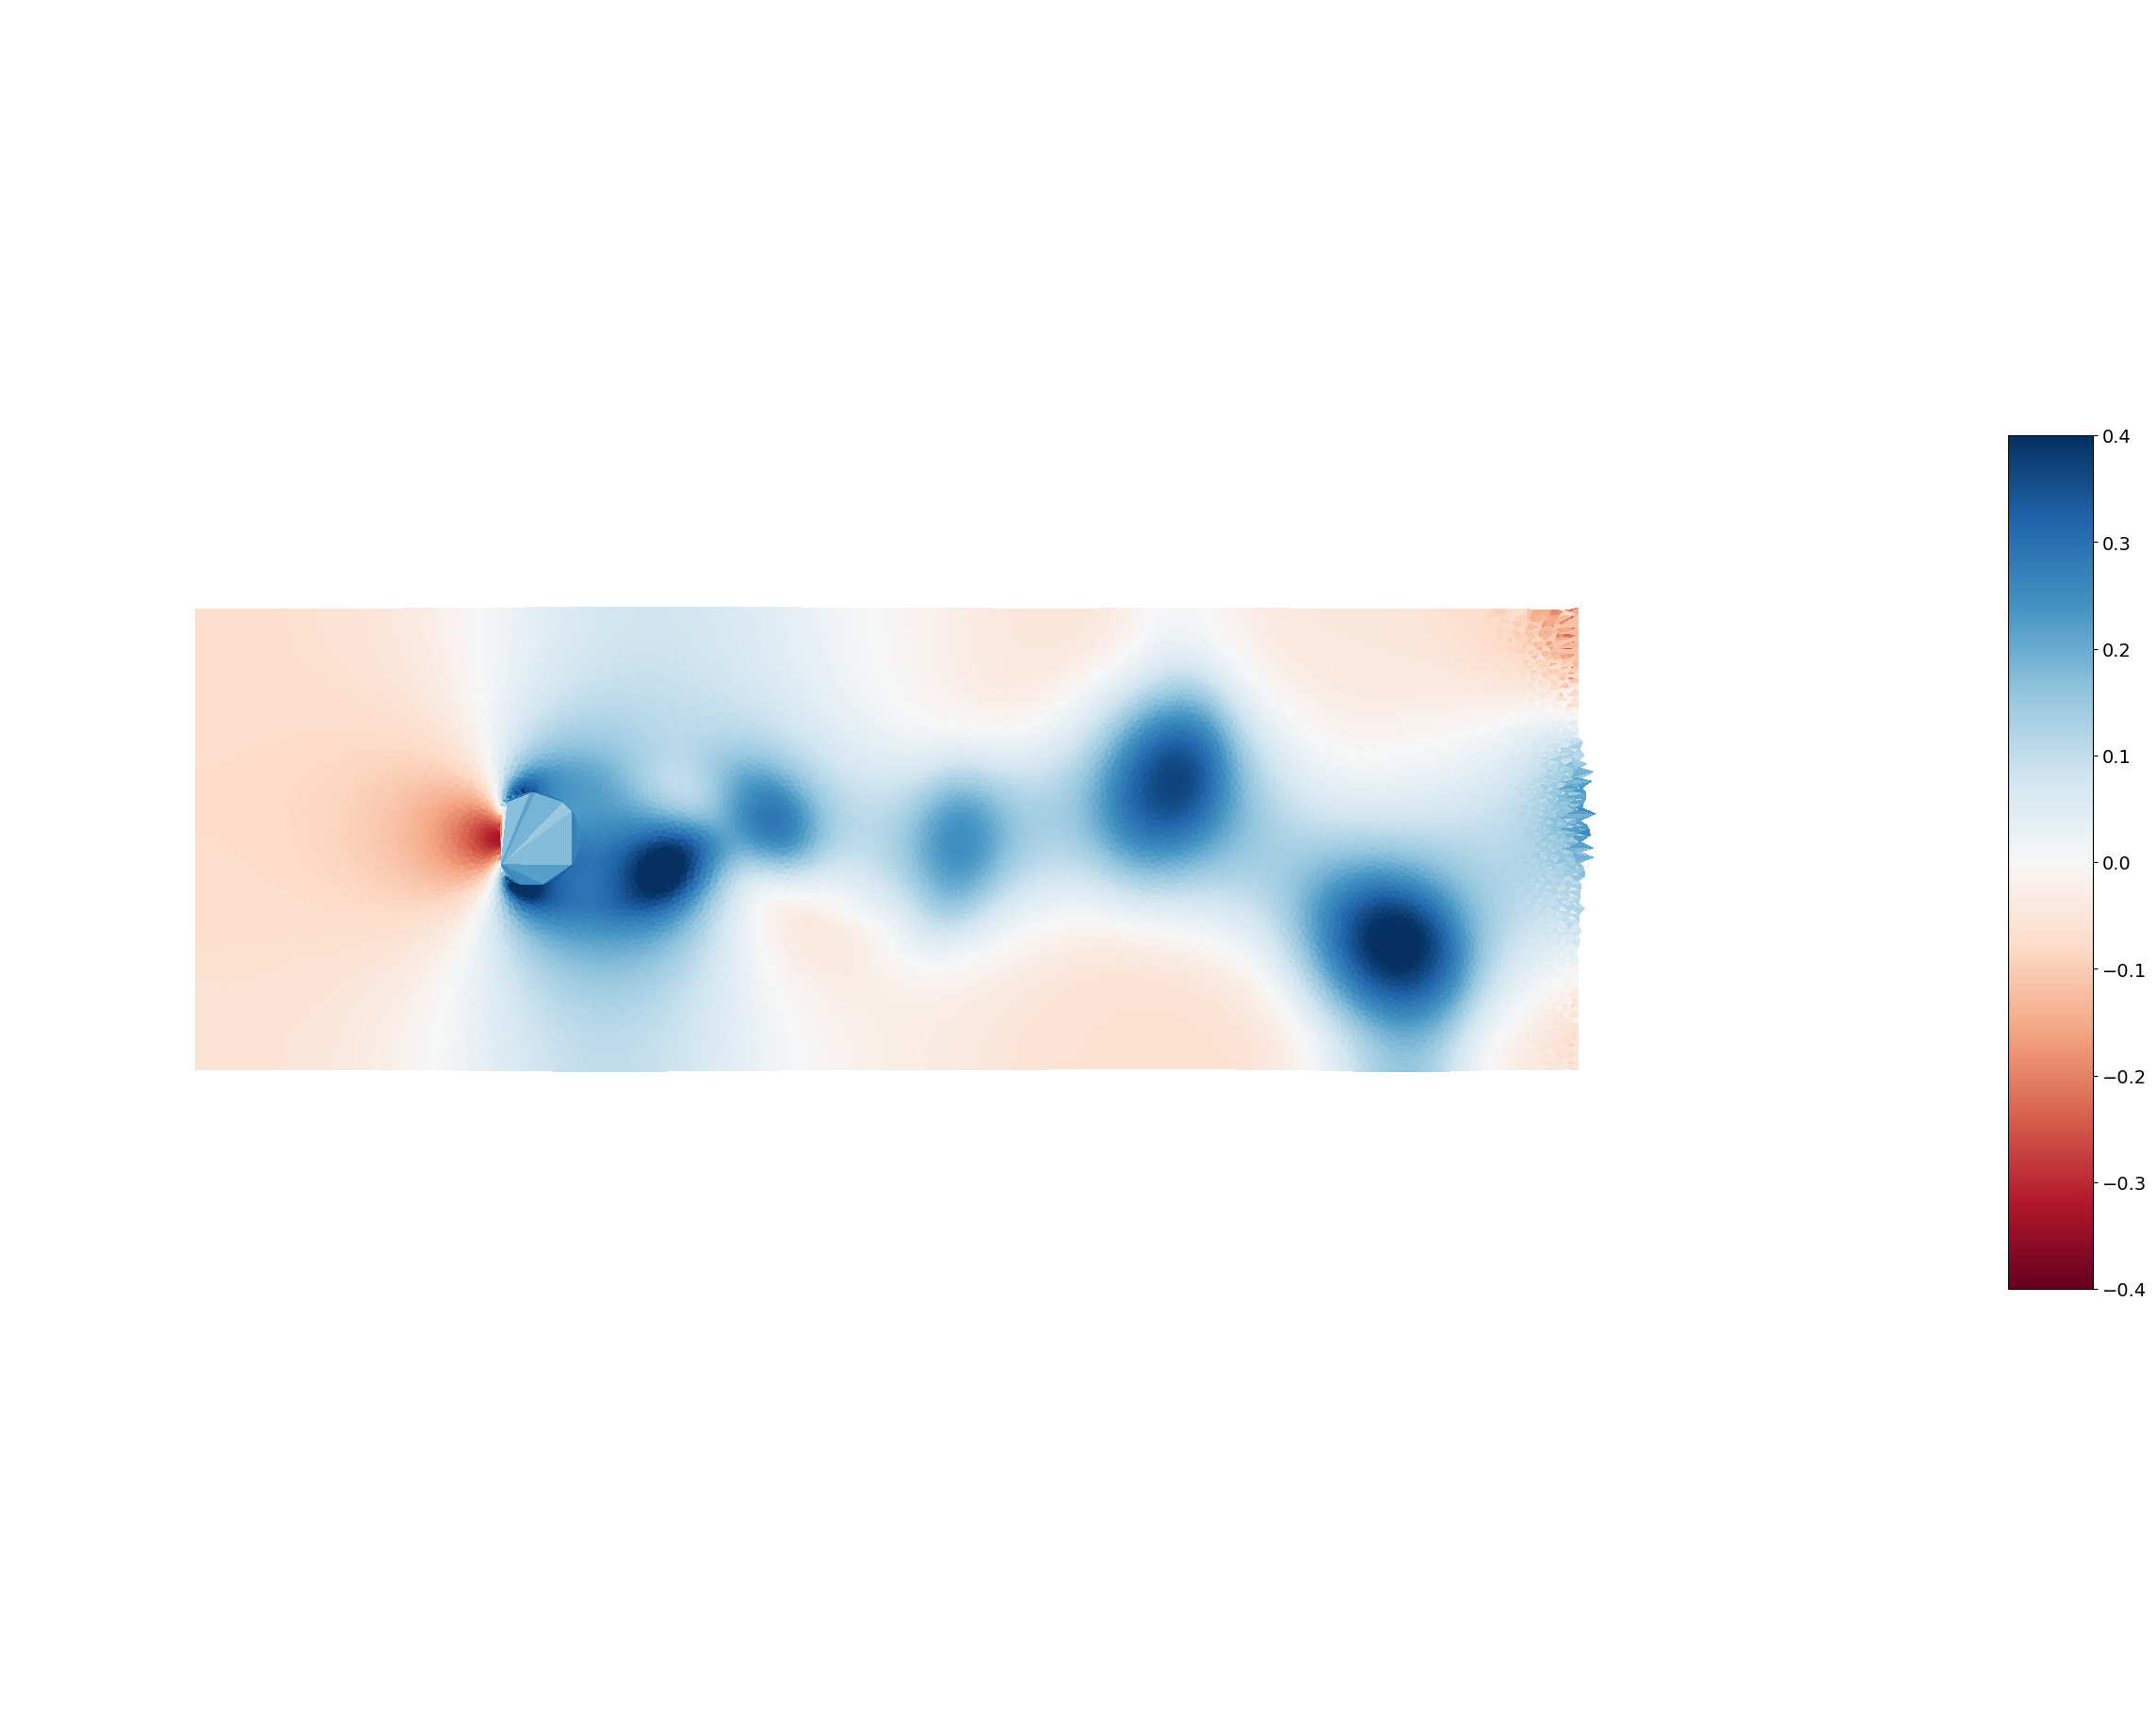

In [44]:
    fig = plt.figure(figsize=(80,80))
    ax = fig.add_subplot(3, 1, 1, projection='3d')
    my_cmap = plt.get_cmap('RdBu')
    trisurf = ax.plot_trisurf(mesh.points.transpose()[0], mesh.points.transpose()[1], 
                          temp_p,cmap = my_cmap,
                          linewidth = 0.0,
                          antialiased = False,
                          edgecolor = 'none', vmin=-0.4, vmax=0.4) 
    c = fig.colorbar(trisurf, ax = ax, shrink = 0.5, aspect = 10)
    ax.view_init(elev=90, azim=-90)
    ax.set_box_aspect([3,1,1])
    plt.axis('off')